In [27]:
import jax
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn
import sympy as sy
import numpy as np
import sys
sys.path.append("..")
from eql import eqlearner as eql
from eql import custom_functions
from eql.symbolic import get_symbolic_expr, get_symbolic_expr_layer
from typing import List, Tuple, Callable
from functools import partial
import matplotlib.pyplot as plt

In [28]:
import scipy
sys.path.append("../../orient")
from eql.np_utils import flatten, unflatten

In [29]:
#funs = ['sin', 'cos', 'id', 'mul']
funs = ['mul', 'cos', 'sin']
e = eql.EQL(n_layers=1, functions=funs, features=1, use_l0=True, drop_rate=0.3, temperature=2./3)

In [30]:
key = random.PRNGKey(0)
key, k1, k2 = random.split(key, 3)

In [31]:
N = 100
xdim = 1
x = (random.uniform(key, (N, xdim))-.5) * 2
#x = np.array([[1., 2.]]).T
#x = np.linspace(-1, 1, N)[:,None]
#y = x[:,0] + jnp.cos(x[:,1])
y = jnp.cos(x) + 1 - x**2 


def make_mse_func(xbatched, ybatched):
    def mse(params, key):
        def squared_error(x, y):
            pred = e.apply(params, x, deterministic=True, rngs={'l0': key})
            return jnp.inner(y-pred, y-pred)*0.5
        return jnp.mean(jax.vmap(squared_error)(xbatched, ybatched))
    #return jax.jit(mse)
    return mse

def make_l0_func():
    def l0(params, key):
        return e.apply(params, rngs={'l0':key}, method=e.l0_reg)
    return jax.jit(l0)


def my_mse(params, key):
    #pred = e.apply(params, x)
    pred = e.apply(params, x, rngs={'l0': key})
    return jnp.mean((pred-y)**2)
#     def mse(params, key):
#         def err(x,y):
#             pred = e.apply(params, x)
#             return (x-y)**2
#     return jnp.mean(jax.vmap(mse)(xb, yb))

mse_fn = jax.jit(my_mse)#make_mse_func(x, y)
l0_fn = make_l0_func()

params = e.init({'params':k1, 'l0': k2}, x);

c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean


In [32]:
key, _ = random.split(key)
e.apply(params, x, rngs={'l0':key})

c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean
c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean


Array([[ 0.08853967],
       [-0.13015154],
       [-0.09678119],
       [ 0.087517  ],
       [-0.13200417],
       [-0.13845336],
       [-0.11419303],
       [ 0.08671196],
       [-0.0701721 ],
       [ 0.00686772],
       [-0.05799545],
       [ 0.07469562],
       [ 0.06920244],
       [-0.11118751],
       [ 0.04882265],
       [-0.00163973],
       [ 0.08260427],
       [ 0.07675817],
       [-0.06371181],
       [ 0.01232748],
       [-0.08388253],
       [ 0.07334481],
       [-0.11538859],
       [-0.0269792 ],
       [ 0.08540102],
       [ 0.06689867],
       [-0.06093382],
       [ 0.00656039],
       [ 0.08801116],
       [-0.01288298],
       [ 0.07492674],
       [-0.09152374],
       [ 0.08492926],
       [ 0.08846551],
       [-0.13184963],
       [-0.13690206],
       [-0.12667875],
       [ 0.08137362],
       [-0.09596881],
       [-0.02146488],
       [-0.03495042],
       [ 0.04340443],
       [ 0.08215246],
       [ 0.0842502 ],
       [-0.09938774],
       [ 0

In [33]:
def loss(params, key):
    return mse_fn(params, key) + 1e-1*l0_fn(params, key)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

In [34]:
spec, flat = flatten(params)

In [35]:
key, k1 = random.split(key)
loss(params, key)

c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean
c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean


Array(4.096766, dtype=float32)

In [36]:
def np_fn(params, key):
    params = unflatten(spec, params)
    
    key = jax.random.fold_in(key, np_fn.counter)
    loss, grad = loss_grad_fn(params, key)
    _, grad = flatten(grad)
    
    print(loss)
    np_fn.counter += 1

    return loss, np.array(grad)
np_fn.counter = 0

In [37]:
spec, flat = flatten(params)

In [38]:
key, _ = random.split(key)
x0, _, info = scipy.optimize.fmin_l_bfgs_b(
        np_fn,
        args=[key],
        x0 = np.array(flat),
        maxfun=2000,
        factr=1.,
        m=500,
        pgtol=1e-20,
        maxls = 1000)
print(mse_fn(unflatten(spec, x0), key))
flat = x0

4.835133
1.6779506
0.87388027
0.8492927
0.8293707
0.8373783
0.8190908
0.82326007
0.91104746
0.8342121
0.8321759
0.83094895
0.83264154
0.81103826
0.8186477
0.8185697
0.8262977
0.8312088
0.8256296
0.83413494
0.8342558
0.17817561


In [39]:
# for i in range(1000):
#     key, k1 = random.split(key)
#     x0, _, info = scipy.optimize.fmin_l_bfgs_b(
#         np_fn,
#         args=[key],
#         x0 = np.array(flat),
#         maxfun=10,
#         factr=1,
#         m=30,
#         pgtol=1e-12)
#     if i % 99 == 0:
#         print(mse_fn(unflatten(spec,x0), key))
#         #print(l0_fn(unflatten(spec,x0), key))
#     flat = x0

In [40]:
symb = get_symbolic_expr(unflatten(spec, x0), funs)[0]
#symb = get_symbolic_expr(unflatten(spec,flat), funs)[0]
outs = sy.lambdify("x0", symb)(x[:,0])#, x[:,1], x[:,2])
#outs = sy.lambdify("x0, x1, x2", symb)(x[:,0])#, x[:,1], x[:,2])

In [41]:
unflatten(spec, x0)

{'params': {'last': {'bias': array([1.35439975]),
   'kernel': array([[ 0.11104736],
          [ 0.18729694],
          [-1.25634826]]),
   'qz_loga': array([[0.5677041 ],
          [0.80420347],
          [0.85719934]])},
  'layers_0': {'linear_layer': {'bias': array([0.02407459, 0.22010836, 0.00414664, 0.33835922]),
    'kernel': array([[-0.71767824, -0.01345287, -0.44910399, -1.9813176 ]]),
    'qz_loga': array([[0.84071643, 0.82365202, 0.84768373, 0.7967196 ]])}}}}

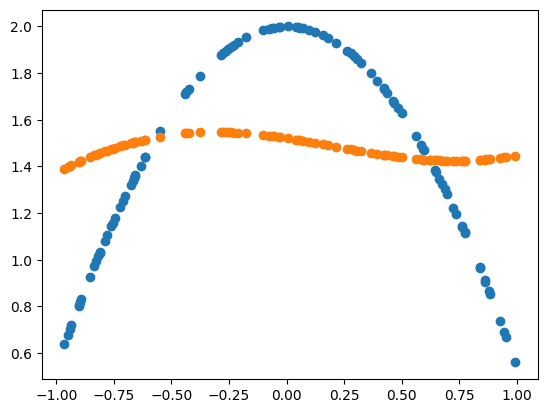

In [42]:
plt.scatter(x,y)
#plt.scatter(x,e.apply(unflatten(spec, x0), x),alpha=.3,marker='.')
plt.scatter(x,outs)

In [43]:
import optax
tx = optax.adam(learning_rate=1e-2)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

In [44]:
for i in range(1000):
    key, k1 = random.split(key)
    loss_val, grads = loss_grad_fn(params, key)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 99 == 0:
        print(loss_val)
        print(mse_fn(params, key))
        print(l0_fn(params, key))

5.2200294
4.4514995
6.439699
1.0055645
0.3695967
6.3296413
0.85384935
0.23683482
6.158529
0.68137497
0.109599076
5.7089934
0.6243007
0.113140665
5.102709
0.52090603
0.047935
4.706841
0.47965935
0.044059314
4.346407
0.41471803
0.0059423135
4.086587
0.4017221
0.0060896324
3.953177
0.41328397
0.025768828
3.8701863
0.38644823
0.0066129235
3.795898


In [45]:
symb = get_symbolic_expr(params, funs, use_l0=True)[0]


In [46]:
symb

1.26335967471636 - 0.734513998031616*sin(2.23690605163574*x0 - 1.58385705947876)

In [47]:
jit_apply = jax.jit(e.apply, static_argnames='deterministic')

In [48]:
jit_part = partial(jit_apply, params)
#jax.grad(jit_part)(x)

In [49]:
e.apply(params, rngs={'l0': k1}, method=e.l0_reg)

Array(3.7892332, dtype=float32)

In [50]:
k1, _ = random.split(k1)
e.apply(params, x, deterministic=False, rngs={'l0': k1})

c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean
c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean


Array([[1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],
       [1.9510235],


In [51]:
k1, _ = random.split(k1)
jit_apply(params, x, deterministic=False, rngs={'l0': k1})

c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean
c:\users\simon\bachelorarbeit\eql\eql\l0_dense.py:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return random.normal(key, shape, dtype) * stddev + mean


Array([[1.302842  ],
       [1.1992404 ],
       [1.624079  ],
       [1.2028911 ],
       [1.1575269 ],
       [0.86422485],
       [1.448066  ],
       [1.1681999 ],
       [1.8048979 ],
       [1.9798905 ],
       [1.8633407 ],
       [0.9365747 ],
       [0.8753398 ],
       [1.4832147 ],
       [1.8718191 ],
       [1.9824466 ],
       [1.0595552 ],
       [1.6460285 ],
       [1.83754   ],
       [1.9752308 ],
       [1.7220604 ],
       [0.9202595 ],
       [1.4333705 ],
       [1.9580009 ],
       [1.486779  ],
       [0.85307133],
       [1.850429  ],
       [1.9800813 ],
       [1.381328  ],
       [1.9774113 ],
       [1.669286  ],
       [1.666693  ],
       [1.1128647 ],
       [1.2784611 ],
       [1.1612102 ],
       [1.0026395 ],
       [1.2666326 ],
       [1.0359519 ],
       [1.6309272 ],
       [1.9673142 ],
       [1.9406166 ],
       [1.8966558 ],
       [1.0506023 ],
       [1.0957634 ],
       [1.6014105 ],
       [1.8395207 ],
       [1.2826872 ],
       [1.755

In [52]:
symb = get_symbolic_expr(unflatten(spec, x0), funs)
sy.lambdify("x0, x1, x2", symb[0])(x[:,0], x[:,1], x[:,2])

Array([1.5032835, 1.424153 , 1.4428592, 1.4860289, 1.4244668, 1.4403286,
       1.4302775, 1.4793537, 1.4649689, 1.5255649, 1.4753202, 1.423879 ,
       1.4051934, 1.4322181, 1.5459427, 1.5198252, 1.4559057, 1.5419061,
       1.4704659, 1.529038 , 1.4533851, 1.4191027, 1.429546 , 1.500887 ,
       1.527939 , 1.3978446, 1.4728272, 1.5253643, 1.5148988, 1.5117197,
       1.5433146, 1.4470791, 1.4679155, 1.4993355, 1.4244225, 1.4294944,
       1.424486 , 1.4502524, 1.443503 , 1.505202 , 1.4944999, 1.5443759,
       1.4537866, 1.4641732, 1.4408171, 1.5470842, 1.4247136, 1.4576684,
       1.5461389, 1.4219878, 1.546352 , 1.4022858, 1.4277796, 1.4292371,
       1.5147202, 1.4388543, 1.5416814, 1.5467191, 1.5472165, 1.5016288,
       1.4250349, 1.426089 , 1.4247147, 1.5049098, 1.4246944, 1.484001 ,
       1.4737096, 1.4492921, 1.4254793, 1.4317383, 1.4276131, 1.4680977,
       1.4312086, 1.5094044, 1.4297115, 1.4395374, 1.5130405, 1.4470209,
       1.4492062, 1.4926063, 1.4897624, 1.5150118, 

In [53]:
sy.lambdify(sy.symbols("x0, x1"), symb[1], "numpy")(x[:,0],x[:,1])

IndexError: list index out of range